<a href="https://colab.research.google.com/github/raitharnett/tensorflow-great-barrier-reef/blob/main/cots_mask_r_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [16]:
%%bash
git clone --depth 1 https://github.com/tensorflow/models
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1683460 sha256=82a3e166bac1dee1b5029bab4180897c873303a726197373c645d31b55277d26
  Stored in directory: /tmp/pip-ephem-wheel-cache-tgbir3gg/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=a1bb477c9afc3de941a614e280936bebb16f3fa0ed5796a60c5127545cecdd49
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=eee6ff83158e2a06600acfc05d207aabf0332687f29419e6599846ccd191159e
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=488360b54bbdff4c002b4d2f38aa7013725a7ed4117918da7

Cloning into 'models'...
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [45]:
# https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')
print(f"TF version: {tf.__version__}")

import pandas as pd
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

TF version: 2.7.0


In [6]:
detector = hub.load("https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1")

[100.]


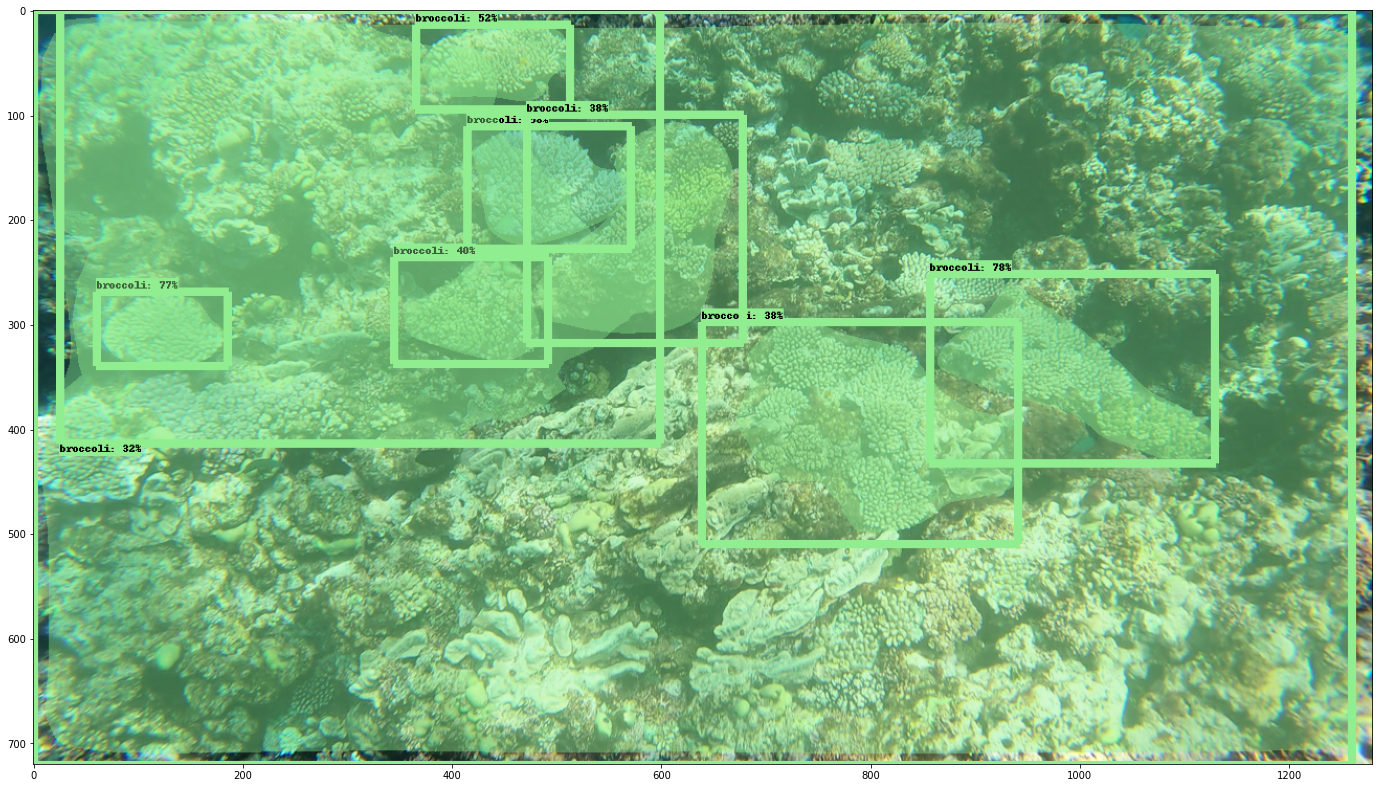

In [46]:
import cv2 as cv 
from google.colab.patches import cv2_imshow

COTS_DATA = '/content/drive/MyDrive/cots/tensorflow-great-barrier-reef'
COTS_DATA_IMAGES = os.path.join(COTS_DATA,'train_images')
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
cots_df = pd.read_csv(os.path.join(COTS_DATA,'train.csv'))
cots_df['image_path'] = cots_df.apply(lambda r: os.path.join(COTS_DATA_IMAGES,f"video_{r.video_id}",f"{r.video_frame}.jpg"), axis=1)
cots_df_elements = cots_df.sample(n=1)

for _, row in cots_df_elements.iterrows():
  image_tensor = tf.io.decode_jpeg(tf.io.read_file(row.image_path), channels=3)
  detector_output = detector(image_tensor[tf.newaxis, ...])
  result = {key:value.numpy() for key,value in detector_output.items()}
  print(result['num_detections'])
  label_id_offset = 0
  image_np =  image_tensor.numpy()
  image_np_with_mask = image_tensor.numpy().copy()
  if 'detection_masks' in result:
    # we need to convert np.arrays to tensors
    detection_masks = tf.convert_to_tensor(result['detection_masks'][0])
    detection_boxes = tf.convert_to_tensor(result['detection_boxes'][0])

    # Reframe the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              detection_masks, detection_boxes,
                image_np.shape[0], image_np.shape[1])
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                        tf.uint8)
    result['detection_masks_reframed'] = detection_masks_reframed.numpy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_mask,
        result['detection_boxes'][0],
        (result['detection_classes'][0] + label_id_offset).astype(int),
        result['detection_scores'][0],
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,
        agnostic_mode=False,
        instance_masks=result.get('detection_masks_reframed', None),
        line_thickness=8)

  plt.figure(figsize=(24,32))
  plt.imshow(image_np_with_mask)
  plt.show()


